# Basic Sanity Check for PartialFlow Training

This notebook is a toy example for comparing the training of a network with and without PartialFlow involved. We define two small neural networks with the exact same architecture and train them on MNIST - the first one as usual in Tensorflow, the second one split into multiple sections. To make a comparison possible, the networks are small enough to be trained on a single GPU without any splits.

We compare the network's losses as well as the training times. The results shown here have been obtained from running the trainings on a NVIDIA GeForce GTX 1070 with 8GB memory.

### MNIST Data

In [1]:
import tensorflow as tf
import numpy as np

# load MNIST data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_images = np.reshape(mnist.train.images, [-1, 28, 28, 1])
train_labels = mnist.train.labels

test_images = np.reshape(mnist.test.images, [-1, 28, 28, 1])
test_labels = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Define Network Architectures

As already mentioned, the network architectures are identical. If you want to compare a vanilla training to one with more splits, just add sections to the network.

In [2]:
from BasicNets import BatchnormNet

def buildSectionNet(sm):
    batch_size = 250
    image, label = tf.train.slice_input_producer([train_images, train_labels])
    image_batch, label_batch = tf.train.batch([image, label], batch_size=batch_size)

    # flag for batch normalization layers
    is_training = tf.placeholder(name='is_training', shape=[], dtype=tf.bool)
    net = BatchnormNet(is_training, image_batch)

    # first network section with initial convolution and three residual blocks
    with sm.new_section():
        with tf.variable_scope('initial_conv'):
            stream = net.add_conv(net._inputs, n_filters=16)
            stream = net.add_bn(stream)
            stream = tf.nn.relu(stream)

        with tf.variable_scope('scale0'):
            for i in range(3):
                with tf.variable_scope('block_%d' % i):
                    stream = net.res_block(stream)

    # second network section strided convolution to decrease the input resolution
    #with sm.new_section():
        with tf.variable_scope('scale1'):
            stream = net.res_block(stream, filters_factor=2, first_stride=2)
            for i in range(2):
                with tf.variable_scope('block_%d' % i):
                    stream = net.res_block(stream)

    # third network section
    with sm.new_section():
        with tf.variable_scope('scale2'):
            stream = net.res_block(stream, filters_factor=2, first_stride=2)
            for i in range(4):
                with tf.variable_scope('block_%d' % i):
                    stream = net.res_block(stream)

    # fourth network section with final pooling and cross-entropy loss
    #with sm.new_section():
        with tf.variable_scope('final_pool'):
            # global average pooling over image dimensions
            stream = tf.reduce_mean(stream, axis=2)
            stream = tf.reduce_mean(stream, axis=1)

            # final conv for classification
            stream = net.add_fc(stream, out_dims=10)

        with tf.variable_scope('loss'):
            loss = tf.nn.softmax_cross_entropy_with_logits(stream, label_batch)
            loss = tf.reduce_mean(loss)

    return loss, is_training


def buildBasicNet():
    batch_size = 250
    image, label = tf.train.slice_input_producer([train_images, train_labels])
    image_batch, label_batch = tf.train.batch([image, label], batch_size=batch_size)

    # flag for batch normalization layers
    is_training = tf.placeholder(name='is_training', shape=[], dtype=tf.bool)
    net = BatchnormNet(is_training, image_batch)

    # first network section with initial convolution and three residual blocks
    with tf.variable_scope('initial_conv'):
        stream = net.add_conv(net._inputs, n_filters=16)
        stream = net.add_bn(stream)
        stream = tf.nn.relu(stream)

    with tf.variable_scope('scale0'):
        for i in range(3):
            with tf.variable_scope('block_%d' % i):
                stream = net.res_block(stream)

    # second network section strided convolution to decrease the input resolution
    with tf.variable_scope('scale1'):
        stream = net.res_block(stream, filters_factor=2, first_stride=2)
        for i in range(2):
            with tf.variable_scope('block_%d' % i):
                stream = net.res_block(stream)

    # third network section
    with tf.variable_scope('scale2'):
        stream = net.res_block(stream, filters_factor=2, first_stride=2)
        for i in range(4):
            with tf.variable_scope('block_%d' % i):
                stream = net.res_block(stream)

    # fourth network section with final pooling and cross-entropy loss
    with tf.variable_scope('final_pool'):
        # global average pooling over image dimensions
        stream = tf.reduce_mean(stream, axis=2)
        stream = tf.reduce_mean(stream, axis=1)

        # final conv for classification
        stream = net.add_fc(stream, out_dims=10)

    with tf.variable_scope('loss'):
        loss = tf.nn.softmax_cross_entropy_with_logits(stream, label_batch)
        loss = tf.reduce_mean(loss)

    return loss, is_training

### Setup

Next, we set up both networks, prepare the training, and initialize the session.

In [3]:
from partialflow import GraphSectionManager

# construct network with splits
sm = GraphSectionManager()
with tf.variable_scope('section_net'):
    loss_sec, is_training_sec = buildSectionNet(sm)

opt = tf.train.AdamOptimizer(learning_rate=0.0001)
sm.add_training_ops(opt, loss_sec, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES), verbose=False)
sm.prepare_training()

# construct same network without splits
with tf.variable_scope('basic_net'):
    loss_basic, is_training_basic = buildBasicNet()

opt = tf.train.AdamOptimizer(learning_rate=0.0001)
grads = opt.compute_gradients(loss_basic, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
train_op = opt.apply_gradients(grads)

# initialize the session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
_ = tf.train.start_queue_runners(sess=sess)

## Training

We run 500 training cycles for both networks and keep track of the loss as well as the duration of each training operation.

In [4]:
from time import time

N = 500
losses = np.zeros([2,N], dtype=np.float32)
times = np.zeros([2,N], dtype=np.float32)
for i in range(N):
    start = time()
    losses[0, i] = sm.run_full_cycle(sess, fetches=loss_sec, basic_feed={is_training_sec:True})
    times[0, i] = time() - start

    start = time()
    _, losses[1, i] = sess.run([train_op, loss_basic], feed_dict={is_training_basic:True})
    times[1, i] = time() - start
    
    if i%100 == 0:
        print('Processed %d/%d batches' % (i,N))

Processed 0/500 batches
Processed 100/500 batches
Processed 200/500 batches
Processed 300/500 batches
Processed 400/500 batches


## Evaluation

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

If PartialFlow works correctly, the losses should be very similar for both networks. The training processes mainly differ in the initializations and the order of the inputs.

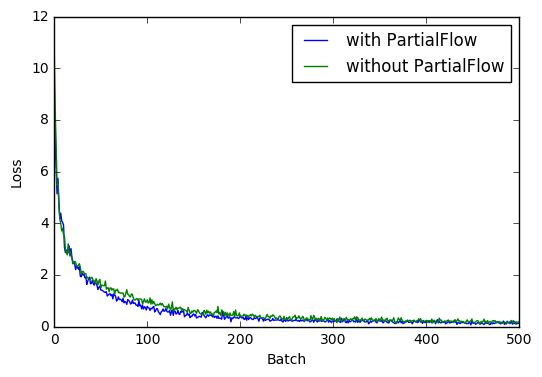

In [6]:
plt.plot(losses.T)
plt.xlabel('Batch')
plt.ylabel('Loss')
_ = plt.legend(['with PartialFlow', 'without PartialFlow'])

PartialFlow trades additional computation time for lower memory consumption. The time overhead depends on the number and position of splits in the graph. Here, we compare the duration of update operations.

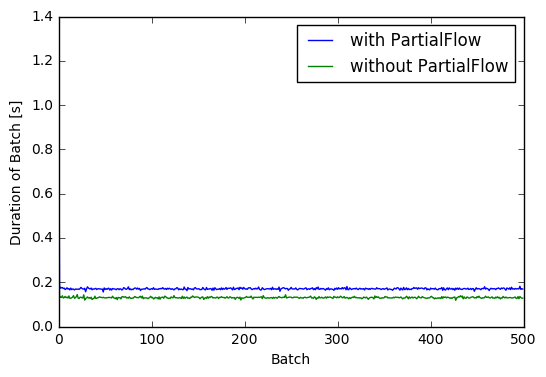

In [7]:
plt.plot(times.T)
plt.xlabel('Batch')
plt.ylabel('Duration of Batch [s]')
_ = plt.legend(['with PartialFlow', 'without PartialFlow'])

Mean relative overhead: 0.30666


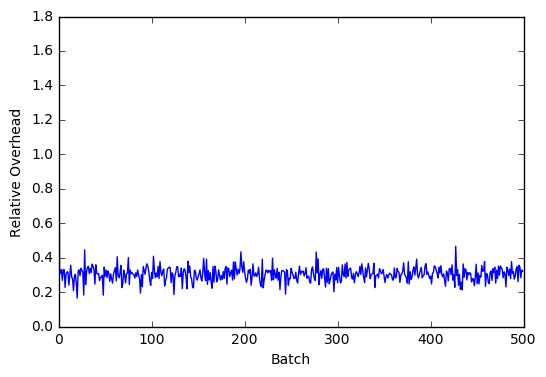

In [8]:
plt.plot(times[0]/times[1] - 1)
plt.xlabel('Batch')
_ = plt.ylabel('Relative Overhead')

print('Mean relative overhead: %.5f' % (np.mean(times[0]/times[1])-1))